# Part 1

In [ ]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import random 
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from tqdm import tqdm
from scipy import stats
from matplotlib import cm
import urllib.request
import statsmodels.api as sm
sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def converged(train_err, prev_train_err_run) -> bool:
    if len(prev_train_err_run) == 0:
        return False
    if(abs(prev_train_err_run[-1] - train_err) < 0.001):
        return True
    else:
        return False

In [ ]:
# Global variables
digits = 10 # for 0 - 9

#data = urllib.request.urlretrieve("http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat", "zipcombo.dat")
#data = np.genfromtxt(data)
data = np.genfromtxt("./zipcombo.dat.txt")

In [ ]:
# Sign function for arrays
def sign(x):
    sign_array = np.ones(x.shape[0])
    sign_array[(x <= 0)] = -1
    return sign_array

# homogeneous poly kernel
def polynomial_kernel(x, y, d):
    k = (np.dot(x.transpose(), y)) ** d
    return k

# Both train and error would be calculated in each run, during training the test error is ignored and 
# train error is used to test for convergence
# confusion_mat = False, find_hardest = False allows us to collect additional data to compute confusion matrix
def fit_one_vs_all(X_train, y_train, X_test, y_test, w, 
                   K_train, K_test, confusion_mat = False, find_hardest = False):
    
    # Train
    y_hat = np.zeros((digits))
    errors = 0
    nsamples = X_train.shape[0]
    for i in range(K_train.shape[0]):
        
        K = K_train[i].reshape(-1,1)

        y_hat = (w @ K).squeeze()
        y_hat_label = np.argmax(y_hat)
        y_true = int(y_train[i])
        # Here we update 
        y_true_augmented = np.ones(digits) * -1
        y_true_augmented[y_true] = 1
        # Filter out classes that we got wrong
        y_err = np.array((y_hat * y_true_augmented) <= 0).squeeze()
        # Update with the above filter
        w[y_err, i] = w[y_err, i] - sign(np.array(y_hat)[y_err])  

        # calculate the errors
        if y_hat_label != y_true:
            errors += 1
    train_error_percentage = (errors / nsamples) * 100


    # Test        
    confusion_matrix = np.zeros((digits, digits))
    nsamples, nfeatures = X_test.shape
    errors = 0
    sample_err_num = np.zeros(nsamples)
    label_count = np.ones((10,1))

    for i in range(nsamples):
        K = K_test[i].reshape(-1,1)
        y_hat = (w @ K).squeeze()
        y_hat_label = np.argmax(y_hat)
        y_true = int(y_test[i])
        label_count[y_true] +=1
        # calculate the errors
        if y_hat_label != y_true:
            errors += 1
            
            if confusion_mat == True :
                confusion_matrix[y_true, y_hat_label] += 1
                
            if find_hardest == True : 
                sample_err_num[i] += 1
            
    test_error_percentage = (errors / nsamples)*100
    
    if confusion_mat == True and find_hardest == True:
        confusion_matrix /= label_count
        return (train_error_percentage, test_error_percentage, confusion_matrix, sample_err_num)
    
    elif find_hardest == True :
        return train_error_percentage, test_error_percentage, sample_err_num
    elif confusion_mat == True:
        confusion_matrix /= label_count
        return train_error_percentage, test_error_percentage, confusion_matrix,
    
    else :
        return train_error_percentage, test_error_percentage 


In [ ]:
def train_for_D(D, runs, epochs):
    traning_err = [] 
    testing_err = [] 
    
    for d in tqdm(D):
        training_err_run = [] 
        testing_err_run = [] 

        for run in runs:
            X_train, X_test, y_train, y_test = train_test_split(data[: , 1:], data[: , 0], test_size = 1/5, shuffle=True) # random split every time
            w = np.zeros((digits, X_train.shape[0])) 
            # Compute kernels here for better performance
            K_train = polynomial_kernel(X_train.T, X_train.T, d)
            K_test = polynomial_kernel(X_test.T, X_train.T, d)
            training_err_epoch = []
            testing_err_epoch = []
            for epoch in range(epochs):
                trn_err, tst_err = fit_one_vs_all(X_train, y_train, X_test, y_test, w, K_train, K_test) 
                # Check for convergence
                if converged(trn_err, training_err_epoch):
                    break;
                training_err_epoch.append(trn_err)
                testing_err_epoch.append(tst_err)
                
            #Only accumulate the trn and tst err for the last epoch
            training_err_run.append(trn_err)
            testing_err_run.append(tst_err)

        traning_err.append(training_err_run)
        testing_err.append(testing_err_run)

    mean_train_err = []
    std_train_err = []
    mean_test_err = []
    std_test_err = []    
    for d in D:
        mean_train_err.append(np.mean(traning_err[d-1]))
        std_train_err.append(np.std(traning_err[d-1]))
    
    for d in D :
        mean_test_err.append(np.mean(testing_err[d-1]))
        std_test_err.append(np.std(testing_err[d-1]))
    return mean_train_err, std_train_err, mean_test_err, std_test_err

### Q1.1
degrees = np.arange(1,8) 
runs = np.arange(1,21) 
epochs = 10

mean_train_err, std_train_err, mean_test_err, std_test_err = train_for_D(degrees, runs, epochs)


100%|██████████| 7/7 [28:28<00:00, 244.08s/it]


In [ ]:
vals = np.char.add(np.char.mod('%.3f', mean_train_err),"±")
vals = np.char.add(vals,np.char.mod('%.3f', std_train_err))

vals1 = np.char.add(np.char.mod('%.3f', mean_test_err),"±")
vals1 = np.char.add(vals1,np.char.mod('%.3f', std_test_err))
result = pd.DataFrame(data = np.vstack((vals, vals1)))
result.columns = ["d : 1","d : 2", "d : 3","d : 4","d : 5", "d : 6", "d : 7"]
result.index = ["train_err_mean ± std","test_err_mean ± std"]

result

,d : 1,d : 2,d : 3,d : 4,d : 5,d : 6,d : 7
train_err_mean ± std,5.697±0.642,0.122±0.083,0.097±0.129,0.045±0.023,0.038±0.022,0.023±0.015,0.025±0.021
test_err_mean ± std,9.145±1.559,3.202±0.385,2.944±0.471,2.640±0.362,2.723±0.413,2.707±0.334,2.790±0.451


# Q1.2 + 1.3


In [ ]:
def findDStar(D, X_train, y_train, epochs):
    total_training_err = [] 
    total_val_err = [] 
    
    fold = KFold(5,shuffle=False)
    
    for d in D:
        training_err = []
        validation_err = []
        for train_index, val_index in fold.split(X_train): # repeat 5 times for each d
            X_train_k, X_val, y_train_k, y_val = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
            K_train = polynomial_kernel(X_train_k.T, X_train_k.T, d)
            K_val = polynomial_kernel(X_val.T, X_train_k.T, d)
            w = np.zeros((10, X_train_k.shape[0])) 

            training_err_epoch = [] 
            validation_err_epoch = [] 

            for epoch in range(epochs):
                trn_err, val_err = fit_one_vs_all(X_train_k, y_train_k, X_val, y_val, w, K_train, K_val) 
                # Check for convergence
                if converged(trn_err, training_err_epoch):
                    break
                training_err_epoch.append(trn_err)
                validation_err_epoch.append(val_err)

            training_err.append(training_err_epoch[-1])
            validation_err.append(validation_err_epoch[-1])

        total_training_err.append(np.mean(training_err))
        total_val_err.append(np.mean(validation_err))
    return np.argmin(total_val_err) + 1

# Q1.2        
degrees = np.arange(1,8)
runs = np.arange(0,20)
epochs = 10
dStars = []
training_err = []
testing_err = []

# Q1.3
confusion_mat = np.zeros((20,10,10))
sample_err_num = 0 

for run in tqdm(runs):
    X_train, X_test, y_train, y_test = train_test_split(data[: , 1:], data[: , 0], test_size = 1/5, shuffle=True)

    # Perform cross-validation using only training set
    dStar = findDStar(degrees,X_train, y_train, 5)
    dStars.append(dStar)
    
    # Retrain using the full set and dStar
    w = np.zeros((10, X_train.shape[0])) 
    K_train = polynomial_kernel(X_train.T, X_train.T, dStar)
    K_test = polynomial_kernel(X_test.T, X_train.T, dStar)
    K_find_hardest = polynomial_kernel(data[:, 1:].T, X_train.T, dStar)
    training_err_epoch = [] 
    testing_err_epoch = [] 
    for epoch in range(epochs):     
        trn_err, tst_err = fit_one_vs_all(X_train, y_train, X_test, y_test, w, K_train, K_test) 
        # Check for convergence
        if converged(trn_err, training_err_epoch):
            break
        training_err_epoch.append(trn_err)
        testing_err_epoch.append(tst_err)
    training_err.append(training_err_epoch[-1])
    testing_err.append(testing_err_epoch[-1])

    #Q1.3 Accumulate confusion matrix 
    _, _, confusion_mat_run = fit_one_vs_all(X_train, y_train, X_test, y_test, w, 
                                                                 K_train, K_test, confusion_mat=True)
    #Q1.4 Save the hardest to predict for the whole dataset
    _, _, sample_err_num_run = fit_one_vs_all(X_train, y_train, data[:,1:], data[: , 0], w, 
                                                                 K_train, K_find_hardest, find_hardest=True)
    confusion_mat[run] = confusion_mat_run
    sample_err_num += sample_err_num_run

100%|██████████| 20/20 [1:06:30<00:00, 199.53s/it]


In [ ]:
testing_err_result = np.char.add(np.char.mod('%.3f', np.mean(testing_err)),"±")
testing_err_result = np.char.add(testing_err_result,np.char.mod('%.3f', np.std(testing_err)))

dStars_result = np.char.add(np.char.mod('%.3f', np.mean(dStars)),"±")
dStars_result = np.char.add(dStars_result,np.char.mod('%.3f', np.std(dStars)))
print("mean test error ± std: " + str(testing_err_result))
print("mean d∗ with std: " + str(dStars_result))

d_star_final = np.mean(dStars)

mean test error ± std: 3.164±1.708
mean d∗ with std: 5.100±0.889


# Q1.3

              y_hat : 0    y_hat : 1  ...    y_hat : 8    y_hat : 9
y_true : 0  0.000±0.000  0.000±0.001  ...  0.000±0.001  0.001±0.001
y_true : 1  0.000±0.000  0.000±0.000  ...  0.001±0.002  0.001±0.002
y_true : 2  0.005±0.005  0.001±0.002  ...  0.004±0.004  0.001±0.002
y_true : 3  0.001±0.002  0.001±0.002  ...  0.010±0.009  0.001±0.002
y_true : 4  0.001±0.002  0.004±0.004  ...  0.001±0.002  0.011±0.011
y_true : 5  0.007±0.007  0.001±0.002  ...  0.007±0.006  0.003±0.004
y_true : 6  0.009±0.006  0.003±0.003  ...  0.003±0.004  0.000±0.000
y_true : 7  0.001±0.002  0.002±0.003  ...  0.003±0.004  0.011±0.006
y_true : 8  0.008±0.007  0.003±0.004  ...  0.000±0.000  0.001±0.003
y_true : 9  0.001±0.002  0.000±0.001  ...  0.000±0.001  0.000±0.000

[10 rows x 10 columns]


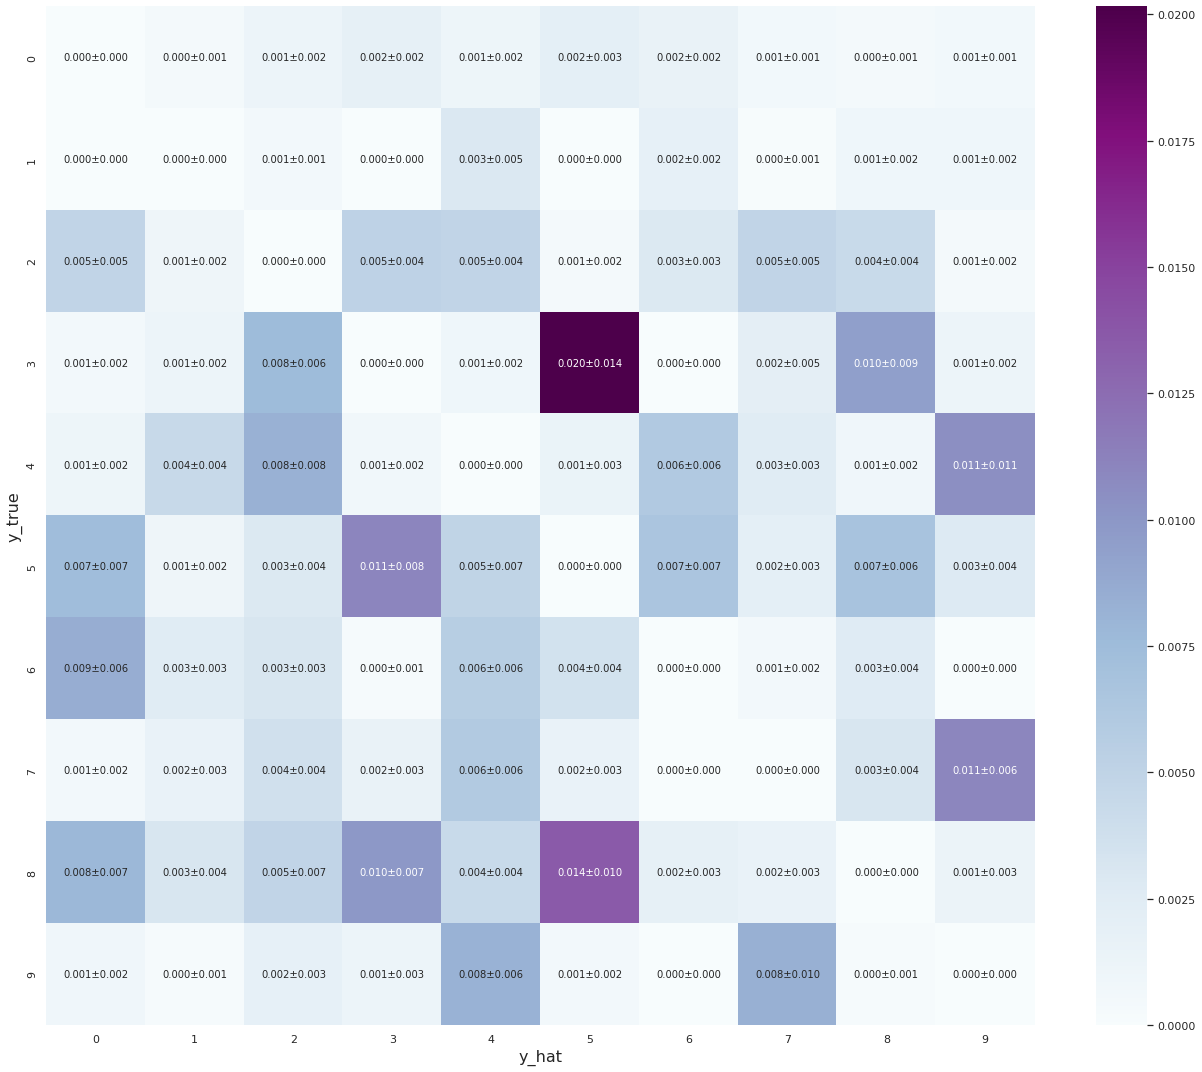

In [ ]:
confusion_raw = confusion_mat
conf_mat_mean = np.mean(confusion_raw, axis=0)
conf_mat_std = np.std(confusion_raw, axis=0)

# Create a dataframe of the confusion matrix 
vals = np.char.add(np.char.mod('%.3f', conf_mat_mean),"±")
vals = np.char.add(vals,np.char.mod('%.3f', conf_mat_std))
confusion_matrix = pd.DataFrame(data = vals)
confusion_matrix.columns = ["y_hat : 0","y_hat : 1","y_hat : 2", "y_hat : 3","y_hat : 4","y_hat : 5", "y_hat : 6", "y_hat : 7","y_hat : 8", "y_hat : 9"]
confusion_matrix.index = ["y_true : 0","y_true : 1","y_true : 2", "y_true : 3","y_true : 4","y_true : 5", "y_true : 6", "y_true : 7","y_true : 8", "y_true : 9"]

print(confusion_matrix)
confusion_matrix = np.array(confusion_matrix)
labels = [x for x in range(10)]
# plt.figure(figsize = (18, 18))
fig, ax = plt.subplots(figsize=(18, 15))
heatmap = sns.heatmap(conf_mat_mean, annot=confusion_matrix, fmt="", ax=ax)
heatmap.set_xlabel('y_hat', size=16)
heatmap.set_ylabel('y_true', size=16)
fig.tight_layout()



# Q1.4

[5296 8261 5145 3930 3639]


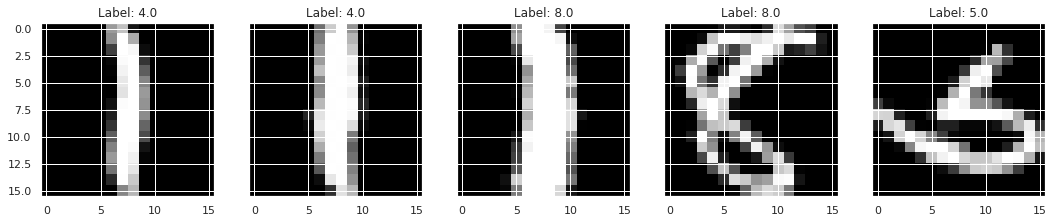

In [ ]:
hardest_digits = np.argsort(sample_err_num)[-5:]
hardest_digits = hardest_digits[::-1]
print(hardest_digits)

fig,axs = plt.subplots(1,5, sharey=True, figsize=(18,18))

for i in range(len(hardest_digits)):
    axs[i].title.set_text(("Label: " + np.str(data[:, 0][hardest_digits[i]])))
    axs[i].imshow(np.reshape(data[:, 1:][hardest_digits[i]],(16,16)),cmap='gray')

# Q1.5

In [ ]:
# Helper
def fast_guassian_kernel(X, Y, c):
    X_norm = np.sum(X ** 2, axis=-1)
    Y_norm = np.sum(Y ** 2, axis=-1)
    K = np.exp(-c * (X_norm[:, None] + Y_norm[None, :] - 2 * np.dot(X, Y.T)))
    return K

In [ ]:
def train_for_C(C, runs, epochs):
    traning_err = [] 
    testing_err = [] 
    
    for c in tqdm(C):
        training_err_run = [] 
        testing_err_run = [] 

        for run in runs:
            X_train, X_test, y_train, y_test = train_test_split(data[: , 1:], data[: , 0], test_size = 1/5, shuffle=True) # random split every time
            w = np.zeros((digits, X_train.shape[0])) 
            K_train = fast_guassian_kernel(X_train, X_train, c)
            K_test = fast_guassian_kernel(X_train, X_test, c)

            training_err_epoch = []
            testing_err_epoch = []
            for epoch in range(epochs):
                trn_err, tst_err = fit_one_vs_all(X_train, y_train, X_test, y_test, w, K_train.T, K_test.T) 
                if converged(trn_err, training_err_epoch):
                    break;
                training_err_epoch.append(trn_err)
                testing_err_epoch.append(tst_err)
            # Only accumulate train and test error for the last epoch
            training_err_run.append(trn_err)
            testing_err_run.append(tst_err)

        traning_err.append(training_err_run)
        testing_err.append(testing_err_run)
    
    mean_train_err = []
    std_train_err = []
    mean_test_err = []
    std_test_err = []  

    for id, c in enumerate(C):
        mean_train_err.append(np.mean(traning_err[id]))
        std_train_err.append(np.std(traning_err[id]))
    
    for id, c in enumerate(C) :
        mean_test_err.append(np.mean(testing_err[id]))
        std_test_err.append(np.std(testing_err[id]))
    
    return mean_train_err, std_train_err, mean_test_err, std_test_err

### Q1.5.1
c_val = [1.0/(2* (2**x)**2) for x in np.arange(1.0,3.5,0.25)]  #some random numbers
runs = np.arange(1,21) 
epochs = 10

mean_train_err, std_train_err, mean_test_err, std_test_err = train_for_C(c_val, runs, epochs)

100%|██████████| 10/10 [36:19<00:00, 217.99s/it]


In [ ]:
vals = np.char.add(np.char.mod('%.3f', mean_train_err),"±")
vals = np.char.add(vals,np.char.mod('%.3f', std_train_err))

vals1 = np.char.add(np.char.mod('%.3f', mean_test_err),"±")
vals1 = np.char.add(vals1,np.char.mod('%.3f', std_test_err))
result = pd.DataFrame(data = np.vstack((vals, vals1)))
result.columns = ["c: " + str("%0.4f" % c) for c in c_val]
result.index = ["train_err_mean+/-std","test_err_mean+/-std"]

result

,c: 0.1250,c: 0.0884,c: 0.0625,c: 0.0442,c: 0.0312,c: 0.0221,c: 0.0156,c: 0.0110,c: 0.0078,c: 0.0055
train_err_mean+/-std,0.006±0.012,0.015±0.017,0.015±0.015,0.019±0.016,0.018±0.012,0.030±0.022,0.026±0.017,0.040±0.022,0.053±0.027,0.124±0.074
test_err_mean+/-std,5.667±0.457,4.976±0.589,4.247±0.359,3.406±0.442,2.981±0.380,2.707±0.288,2.608±0.383,2.551±0.309,2.903±0.446,3.132±0.318


In [ ]:
def findCStar(C, X_train, y_train, epochs):
    total_training_err = [] 
    total_val_err = [] 
    
    fold = KFold(5,shuffle=False)
    
    for c in C:
        training_err = []
        validation_err = []
        for train_index, val_index in fold.split(X_train): # repeat 5 times for each c
            X_train_k, X_val, y_train_k, y_val = X_train[train_index], X_train[val_index], y_train[train_index], y_train[val_index]
            K_train = fast_guassian_kernel(X_train_k, X_train_k, c)
            K_val = fast_guassian_kernel(X_train_k, X_val, c)
            w = np.zeros((10, X_train_k.shape[0])) 

            training_err_epoch = [] 
            validation_err_epoch = [] 

            for epoch in range(epochs):
                trn_err, val_err = fit_one_vs_all(X_train_k, y_train_k, X_val, y_val, w, K_train.T, K_val.T) 
                if converged(trn_err, training_err_epoch):
                    break
                training_err_epoch.append(trn_err)
                validation_err_epoch.append(val_err)
            training_err.append(training_err_epoch[-1])
            validation_err.append(validation_err_epoch[-1])
            
        total_training_err.append(np.mean(training_err))
        total_val_err.append(np.mean(validation_err))
        #print(len(testing_err))
    return np.argmin(total_val_err)
        
c_val = [1.0/(2* (2**x)**2) for x in np.arange(1.0,3.5,0.25)]  #some random numbers
runs = np.arange(1,21)
epochs = 10
cStars = []
training_err = []
testing_err = []
for run in tqdm(runs):
    X_train, X_test, y_train, y_test = train_test_split(data[: , 1:], data[: , 0], test_size = 1/5, shuffle=True)
    cStar = c_val[findCStar(c_val,X_train,y_train, 5)]
    cStars.append(cStar)
    
    training_err_epoch = [] 
    testing_err_epoch = [] 
    w = np.zeros((10, X_train.shape[0])) 
    K_train = fast_guassian_kernel(X_train, X_train, cStar)
    K_test = fast_guassian_kernel(X_train, X_test, cStar)
    for epoch in range(epochs):        
        trn_err, tst_err = fit_one_vs_all(X_train, y_train, X_test, y_test, w, K_train.T, K_test.T) 
        training_err_epoch.append(trn_err)
        testing_err_epoch.append(tst_err)
    
    training_err.append(np.mean(training_err_epoch))
    testing_err.append(np.mean(testing_err_epoch))

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
testing_err_result = np.char.add(np.char.mod('%.3f', np.mean(testing_err)),"±")
testing_err_result = np.char.add(testing_err_result,np.char.mod('%.3f', np.std(testing_err)))

cStars_result = np.char.add(np.char.mod('%.3f', np.mean(cStars)),"±")
cStars_result = np.char.add(cStars_result,np.char.mod('%.3f', np.std(cStars)))
print("mean test error ± std: " + str(testing_err_result))
print("mean c∗ with std: " + str(cStars_result))

mean test error ± std: 2.842±0.300
mean c∗ with std: 0.017±0.004


# Q1.6.1

In [ ]:
def fit_binary_kernel_perceptron(X_train, y_train, X_test, y_test, K_train, K_test, K_train_all,
                                 epoch, y_result_test, y_result_train, i, j):
    """
    Implementing the binary kernel perceptron as depicted in https://en.wikipedia.org/wiki/Kernel_perceptron
    """

    # Number of samples.
    n_samples, _ = X_train.shape

    # Initialize all alphas as zero, create list for training and validation accuracy for each iteration.
    alphas = np.zeros(n_samples, dtype=int)
    train_err_epoch = []
    test_err_epoch = []

    for e in range(epoch):
        #train 
        for sample in range(n_samples):
            u = np.dot(alphas * y_train, K_train[:, sample])
            if y_train[sample] * u <= 0:
                alphas[sample] += 1
        # Calculate predictions and get accuracy for each iteration
        train_pred = [1 if x >= 0 else -1 for x in ((alphas * y_train).dot(K_train))]
        test_pred = [1 if x >= 0 else -1 for x in ((alphas * y_train).dot(K_test))]

        # train_err is used to test for convergence
        train_err = 100 * (train_pred != y_train).sum()/n_samples
        test_err = 100 * (test_pred != y_test).sum() / y_test.shape[0]
        if converged(train_err, train_err_epoch):
            break
        train_err_epoch.append(train_err)
        test_err_epoch.append(test_err)
    
    # Accumulate train prediction from each classifier
    predict_class_1_train = [1 if x >= 0 else 0 for x in ((alphas * y_train).dot(K_train_all))]
    predict_class_2_train = [1 if x < 0 else 0 for x in ((alphas * y_train).dot(K_train_all))]
    y_result_train[:,i] += predict_class_1_train
    y_result_train[:,j] += predict_class_2_train
    # Accumulate test prediction
    predict_class_1_test = [1 if x >= 0 else 0 for x in ((alphas * y_train).dot(K_test))]
    predict_class_2_test = [1 if x < 0 else 0 for x in ((alphas * y_train).dot(K_test))]
    y_result_test[:,i] += predict_class_1_test
    y_result_test[:,j] += predict_class_2_test

    return alphas

In [ ]:
def fit_one_vs_one(training_set, testing_set, d, epoch):
    #Preprocessing
    X_test = testing_set[:, 1:]
    y_test = testing_set[:, 0]
    
    training_error = []
    y_result_test = np.zeros((y_test.shape[0], 10))
    y_result_train = np.zeros((training_set.shape[0], 10))

    # Train 45 classifiers
    for i in range(10):
        for j in range(i+1,10):
            # Create binary classification dataset
            filter = np.where((training_set[:,0] == i) | (training_set[:,0] == j))
            data = training_set[filter] 
            X_train = np.array(data[:,1:])
            y_train = np.array(data[:,0])
            y_train[y_train == j] = -1
            y_train[y_train == i] = 1

            K_train = polynomial_kernel(X_train.T, X_train.T, d).T
            K_test = polynomial_kernel(X_test.T, X_train.T, d).T
            # Kernels to calculate train prediction using each classifier
            K_train_all = polynomial_kernel(training_set[:, 1:].T, X_train.T, d).T
          
            alphas = fit_binary_kernel_perceptron(X_train, y_train, X_test, y_test, K_train, K_test, K_train_all,
                                                  epoch, y_result_test, y_result_train, i , j)
    # Calculate train error
    y_result_train = np.argmax(y_result_train, axis=1)
    train_error = 100 *(y_result_train != training_set[:, 0]).sum() / y_result_train.shape[0]
    # Calculate test error
    y_result_test = np.argmax(y_result_test, axis=1)
    test_error = 100 *(y_result_test != y_test).sum() / y_test.shape[0]

    return train_error, test_error

In [ ]:
def train_for_D_OvO(D, runs, epochs):
    ns, nf = np.shape(data)
    
    traning_err = [] 
    testing_err = [] 
    
    for d in tqdm(D):
        training_err_run = [] 
        testing_err_run = [] 

        for run in runs:
            # Manually separate data
            np.random.shuffle(data)
            training_set = data[0:int(ns*0.8)]
            testing_set = data[int(ns*0.8):]
            trn_err, tst_err = fit_one_vs_one(training_set, testing_set, d, epochs)

            training_err_run.append(trn_err)
            testing_err_run.append(tst_err)

        traning_err.append(training_err_run)
        testing_err.append(testing_err_run)

    mean_train_err = []
    std_train_err = []
    mean_test_err = []
    std_test_err = []    
    for d in D:
        mean_train_err.append(np.mean(traning_err[d-1]))
        std_train_err.append(np.std(traning_err[d-1]))
    
    for d in D :
        mean_test_err.append(np.mean(testing_err[d-1]))
        std_test_err.append(np.std(testing_err[d-1]))
    return mean_train_err, std_train_err, mean_test_err, std_test_err

### Q1.1
degrees = np.arange(1,8) 
runs = np.arange(1,21) 
epochs = 10

mean_train_err, std_train_err, mean_test_err, std_test_err = train_for_D_OvO(degrees, runs, epochs)

In [ ]:
vals = np.char.add(np.char.mod('%.3f', mean_train_err),"±")
vals = np.char.add(vals,np.char.mod('%.3f', std_train_err))

vals1 = np.char.add(np.char.mod('%.3f', mean_test_err),"±")
vals1 = np.char.add(vals1,np.char.mod('%.3f', std_test_err))
result = pd.DataFrame(data = np.vstack((vals, vals1)))
result.columns = ["d : 1","d : 2", "d : 3","d : 4","d : 5", "d : 6", "d : 7"]
result.index = ["train_err_mean ± std","test_err_mean ± std"]

result

,d : 1,d : 2,d : 3,d : 4,d : 5,d : 6,d : 7
train_err_mean ± std,3.042±0.842,0.385±0.169,0.195±0.059,0.156±0.074,0.159±0.083,0.096±0.049,0.122±0.155
test_err_mean ± std,6.417±0.828,3.624±0.340,3.387±0.422,3.430±0.292,3.511±0.305,3.312±0.490,3.527±0.480


# Q1.6.2

In [ ]:
def findDStar_OvO(D, all_training_set, epoch):
    total_training_err = [] 
    total_val_err = [] 
    
    fold = KFold(5,shuffle=False)
    
    for d in D:
        training_err = []
        validation_err = []
        for train_index, val_index in fold.split(all_training_set): # repeat 5 times for each d
            training_set = data[train_index]
            testing_set = data[val_index]

            trn_err, val_err = fit_one_vs_one(training_set, testing_set, d, epoch) 
            training_err.append(trn_err)
            validation_err.append(val_err)
            
        total_training_err.append(np.array([training_err]).mean())
        total_val_err.append(np.array([validation_err]).mean())
        #print(len(testing_err))
    return np.argmin(total_val_err) + 1
        
degrees = np.arange(1,8)
runs = np.arange(1,21)
epochs = 5
dStars = []
training_err = []
testing_err = []
ns, nf = np.shape(data)
for run in tqdm(runs):
    np.random.shuffle(data)
    training_set = data[0:int(ns*0.8)]
    testing_set = data[int(ns*0.8):]
    dStar = findDStar_OvO(degrees, training_set, epochs)
    dStars.append(dStar)
    
    training_err_epoch = [] 
    testing_err_epoch = [] 
    trn_err, tst_err = fit_one_vs_one(training_set, testing_set, dStar, epochs) 

    training_err.append(trn_err)
    testing_err.append(tst_err)

100%|██████████| 20/20 [3:32:51<00:00, 638.60s/it]


In [ ]:
testing_err_result = np.char.add(np.char.mod('%.3f', np.mean(testing_err)),"±")
testing_err_result = np.char.add(testing_err_result,np.char.mod('%.3f', np.std(testing_err)))

dStars_result = np.char.add(np.char.mod('%.3f', np.mean(dStars)),"±")
dStars_result = np.char.add(dStars_result,np.char.mod('%.3f', np.std(dStars)))
print("mean test error ± std: " + str(testing_err_result))
print("mean d∗ with std: " + str(dStars_result))

d_star_final = np.mean(dStars)

mean test error ± std: 3.333±0.304
mean d∗ with std: 4.850±1.195


# Part 2

In [ ]:
data = './twomoons.dat.txt'
data = np.genfromtxt(data)
X , y = data[:, 1:], data[:, 0]

In [ ]:
# Helper functions
def gaussian_weight(x1, x2, c):
    return np.exp( -c * (np.linalg.norm(x1-x2) ** 2))

# Function that calculates the Laplacian matrix
def calc_laplacian(X, c):
    n = X.shape[0]
    w = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            w[i,j] = gaussian_weight(X[i,:], X[j,:], c=c)
    D = np.diag(np.sum(w, axis=1))
    
    return D - w

def spectral_clustering(data, c):
    laplacian = calc_laplacian(data, c)
    eigenvalues , eigenvectors = np.linalg.eig(laplacian)
    sec_smallest = np.argsort(eigenvalues)[1] # select the index corresponding to the second smallest eigenvalue
    v = eigenvectors[: , sec_smallest] # eigenvector corresponding to the second smallest eigenvalue
    y_hat = np.array([-1  if np.sign(x) < 0 else 1 for x in v]) # generate the predictions
    
    return y_hat

def calc_cluster_correctness(labels, predictions):
    # Count the number of times the algorithm found the correct label
    l_plus = np.sum(np.where(predictions * labels > 0, 1 , 0))
    l_minus = len(labels) - l_plus
    correct_clust_perc = np.max([l_plus, l_minus]) / len(labels)
    
    return correct_clust_perc

## Experiments

### Question 1

In [ ]:
### Question 1 ###

c_values = np.array([2**x for x in np.arange(-10, 10.1, step = 0.1)])
# Generate a list of all the different clustering outcomes
predictions = [spectral_clustering(X,c) for c in c_values]
# Calculate the correct cluster percentage for each value of c
accuracy = np.array([ calc_cluster_correctness(y, pred) for pred in predictions ])

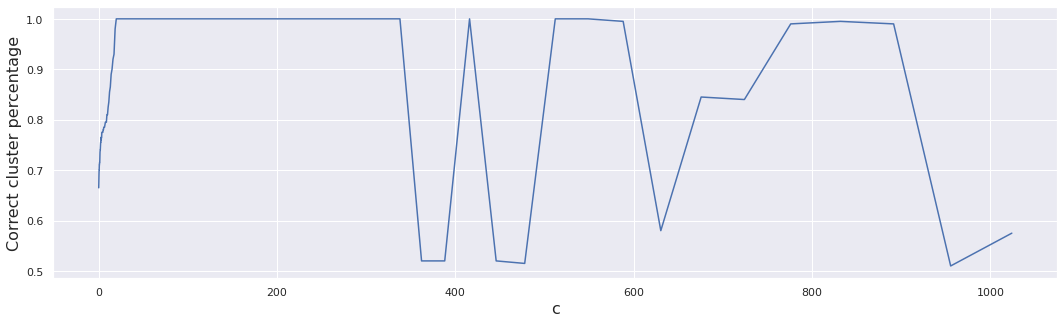

In [ ]:
plt.figure(figsize=(18,5));
plt.plot(c_values, accuracy);
plt.xlabel('c', size=16);
plt.ylabel('Correct cluster percentage', size=16);

In [ ]:
# All of these c values give an accuracy of 100% so we can choose any one of them for the plot
optimal_c = c_values[np.array(accuracy) == 1]
print(optimal_c)

[ 19.69831061  21.11212657  22.627417    24.25146506  25.99207668
  27.85761803  29.85705573  32.          34.2967508   36.75834736
  39.39662123  42.22425314  45.254834    48.50293013  51.98415337
  55.71523605  59.71411146  64.          68.5935016   73.51669472
  78.79324245  84.44850629  90.50966799  97.00586026 103.96830673
 111.4304721  119.42822292 128.         137.1870032  147.03338944
 157.58648491 168.89701258 181.01933598 194.01172051 207.93661347
 222.8609442  238.85644583 256.         274.37400641 294.06677888
 315.17296982 337.79402516 415.87322693 512.         548.74801282]


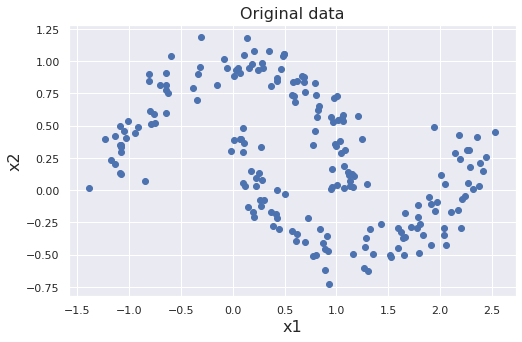

In [ ]:
# Plot of the original data
plt.figure(figsize=(8,5));
plt.scatter(X[:,0] , X[:,1])
plt.title('Original data', size=16);
plt.xlabel('x1', size=16);
plt.ylabel('x2', size=16);

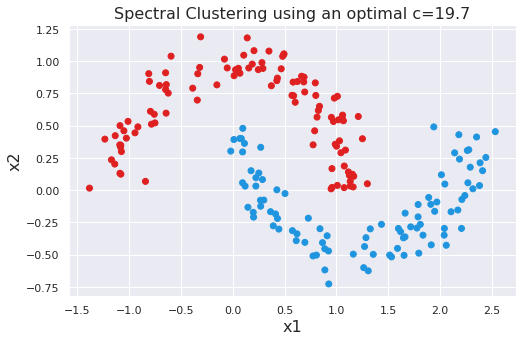

In [ ]:
# Let's see the plotted results for any of the above optimal values of c
y_pred_opt = spectral_clustering(X, c = optimal_c[2])
df_pred = pd.DataFrame({'x1' : X[:,0], 'x2' : X[:,1], 'y_pred' : y_pred_opt})
df_pred['color'] = df_pred['y_pred'].map({-1 : '#DF2020', 1 : '#2095DF'})
plt.figure(figsize=(8,5));
plt.scatter(df_pred['x1'] , df_pred['x2'], c = df_pred['color']);
plt.title(f'Spectral Clustering using an optimal c={optimal_c[0]:.1f}', size=16);
plt.xlabel('x1', size=16);
plt.ylabel('x2', size=16);

### Question 2

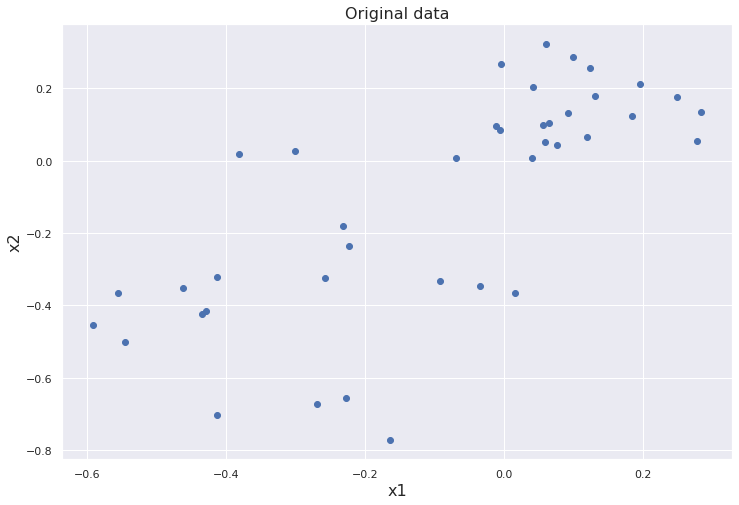

In [ ]:
### Question 2 ###

# Generate the two sets of Gaussian data
np.random.seed(1389)
data_1 = np.random.multivariate_normal(mean = [-0.3, -0.3], cov = 0.04 * np.eye(2), size = 20 )
data_2 = np.random.multivariate_normal(mean = [0.15, 0.15], cov = 0.01 * np.eye(2), size = 20 )
gauss_data = np.vstack((data_1, data_2))
gauss_data = pd.DataFrame({'x1' : gauss_data[:,0], 'x2' : gauss_data[:,1]})
gauss_data['label'] = np.hstack((-1 * np.ones(len(data_1)), np.ones(len(data_1))))

# Plot of the original data
plt.figure(figsize=(12,8));
plt.scatter(gauss_data['x1'] , gauss_data['x2'])
plt.title('Original data', size=16);
plt.xlabel('x1', size=16);
plt.ylabel('x2', size=16);

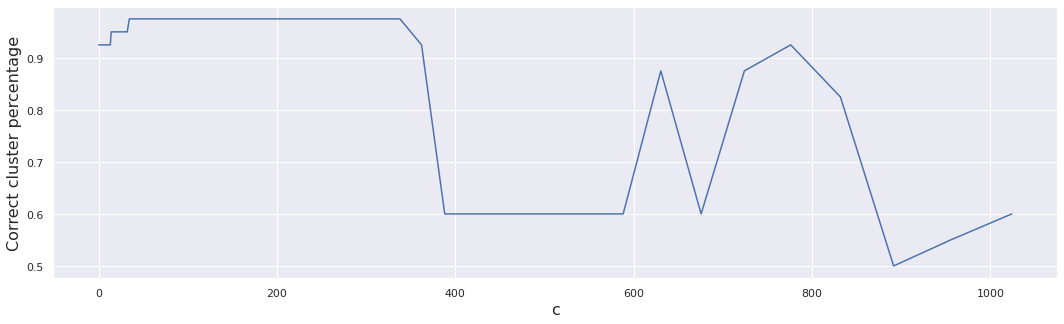

In [ ]:
gauss_predictions = [spectral_clustering(gauss_data.iloc[:, :2].values, c) for c in c_values]
# Calculate the correct cluster percentage for each value of c
gauss_accuracy = np.array([ calc_cluster_correctness(gauss_data['label'].values, pred) for pred in gauss_predictions ])
gauss_c_opt = np.argmax(gauss_accuracy)

plt.figure(figsize=(18,5));
plt.plot(c_values, gauss_accuracy);
plt.xlabel('c', size=16);
plt.ylabel('Correct cluster percentage', size=16);

In [ ]:
c_values[gauss_accuracy == np.max(gauss_accuracy)]

array([ 34.2967508 ,  36.75834736,  39.39662123,  42.22425314,
        45.254834  ,  48.50293013,  51.98415337,  55.71523605,
        59.71411146,  64.        ,  68.5935016 ,  73.51669472,
        78.79324245,  84.44850629,  90.50966799,  97.00586026,
       103.96830673, 111.4304721 , 119.42822292, 128.        ,
       137.1870032 , 147.03338944, 157.58648491, 168.89701258,
       181.01933598, 194.01172051, 207.93661347, 222.8609442 ,
       238.85644583, 256.        , 274.37400641, 294.06677888,
       315.17296982, 337.79402516])

In [ ]:
print(f'Optimal c value is: {c_values[gauss_c_opt]:.4f}')

Optimal c value is: 34.2968


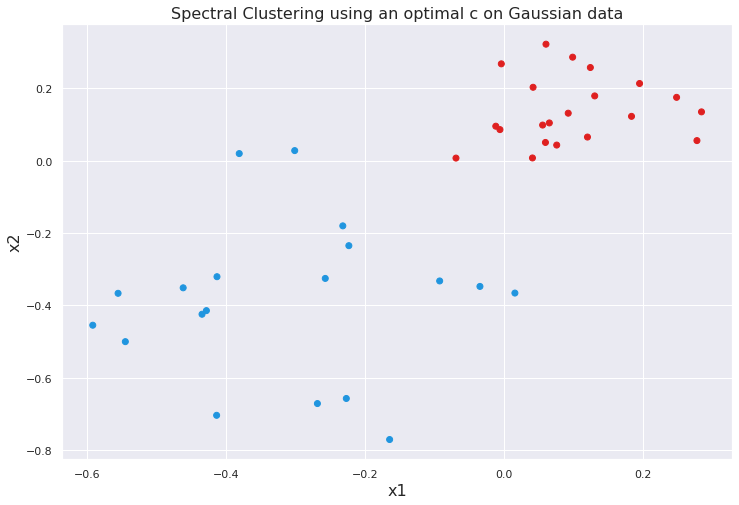

In [ ]:
# Let's see the plotted results for any of the above optimal values of c
gauss_y_pred_opt = spectral_clustering(gauss_data.iloc[:, :2].values, c = c_values[gauss_c_opt])
df_pred = pd.DataFrame({'x1' : gauss_data['x1'], 'x2' : gauss_data['x2'], 'y_pred' : gauss_y_pred_opt})
df_pred['color'] = df_pred['y_pred'].map({-1 : '#DF2020', 1 : '#2095DF'})
plt.figure(figsize=(12,8));
plt.scatter(df_pred['x1'] , df_pred['x2'], c = df_pred['color']);
plt.title('Spectral Clustering using an optimal c on Gaussian data', size=16);
plt.xlabel('x1', size=16);
plt.ylabel('x2', size=16);

### Question 3

In [ ]:
### Question 3 ###

path = './dtrain123.dat.txt'
digit_data = np.genfromtxt(path)
# Only keep data corresponding to the digits 1 or 3
digit_data = np.vstack(((digit_data[ (digit_data[:,0] == 1.)]), digit_data[ (digit_data[:,0] == 3.)]))
X_digit = digit_data[:, 1:]
class_y = np.array([1 if digit == 1 else -1 for digit in digit_data[:,0]])
c_vals = np.arange(0, 0.101, step=0.001)
digit_preds = [spectral_clustering(X_digit, c) for c in c_vals]
ccp = [calc_cluster_correctness(class_y, pred) for pred in digit_preds]

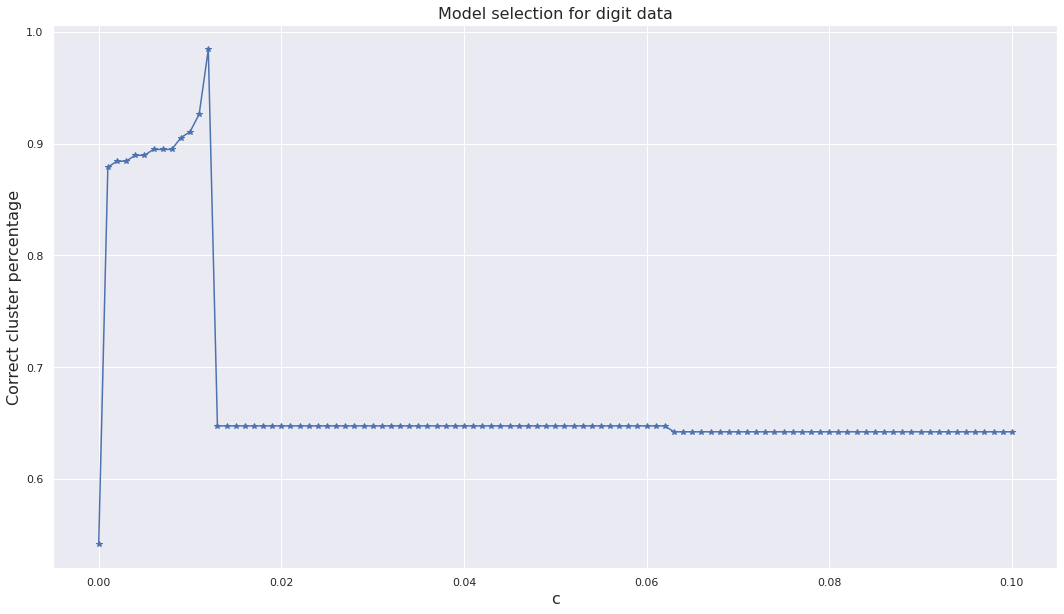

In [ ]:
plt.figure(figsize=(18,10));
plt.plot(c_vals, ccp, '-*');
plt.xlabel('c', size=16);
plt.ylabel('Correct cluster percentage', size=16);
plt.title('Model selection for digit data', size=16);

In [ ]:
print(c_vals[np.argmax(ccp)])

0.012


# Part 3

In [ ]:
# Define some helper functions
def gen_data(n_samples, dimensionality, model=None):
    if model == 'Winnow':
        X = np.random.randint(2, size = (n_samples, dimensionality)) # generate uniformly from {0,1}^n
        y = X[:,0].reshape(-1)
    else:
        X = np.random.randint(2, size = (n_samples, dimensionality)) # generate uniformly from {0,1}^n
        X = np.where(X == 0, X-1, X) # convert the sample to be from {-1,1}^n 
        y = X[:,0].reshape(-1)
    
    return X , y

  # Return a matrix with all nearest neighbour to each point in x_test. \
# k-nearest neighbour to each point can be calculated with the first k-th item in the row vector of the matrix.
def K_NN_matrix(x_train, y , x_test, silence = False):
  
    output = []
    for item in tqdm(x_test, disable= silence): 
         
        point_dist = []
         
        # Loop through each training Data
        point_dist = np.array(np.linalg.norm(x_train - item, axis=1)) 

        # Labels of the first K datapoints (sorted)
        labels = np.array(y)[np.argsort(point_dist)] 
        output.append(labels)

    return np.array(output)

def majority_voting(labels, k):
    output = 0
    # Majority voting & uniform prediction label in case of a tie
    if np.count_nonzero(labels[:k] == 1) == np.count_nonzero(labels[:k] == -1):
        output = random.randint(-1, 1)
    else:
        output = stats.mode(labels[:k])[0].item()
 
    return output

def fit_classic_perceptron(X, Y):
    '''
    Implementation of the perceptron algorithm of slide 33.
    '''
    w = np.zeros(X.shape[1])
    mistakes = 0
    
    for t in range(X.shape[0]):
        x , y = X[t, :] , Y[t]
        y_hat = np.sign(np.sum(w * x))
        if y_hat * y <= 0: # if mistake occurs
            mistakes += 1
            w += y * x
    
    return w

def fit_winnow(X, Y):
    '''
    Implementation of the winnow algorithm of slide 56.
    '''
    dim = X.shape[1] # dimensionality of the data
    w = np.ones(dim)
    mistakes = 0
    
    for t in range(X.shape[0]):
        x , y = X[t, :] , Y[t]
        y_hat = 1 if np.sum(w * x) >= dim else 0 
        if y_hat != y: # if mistake occurs
            mistakes += 1
            w *= np.array([2.0**((y-y_hat)*x_t_i) for x_t_i in x])
    
    return w

In [ ]:
def estimate_sample_complexity(model, max_dim, test_set_size=1000, n_runs=15):
    '''
    Returns two arrays, the first one is the dimensionality and the second is the estimated sample complexity.
    '''
    assert model in ('Linear Regression', 'Winnow', 'KNN', 'Perceptron')
    
    n_range = np.arange(1, max_dim+1)
    sample_comp = [] # store the sample complexity for each n value considered
    
    for n in n_range: # for each dimension
        m = 1 # start from m=1

        gen_error = 1
        while gen_error > 0.1: # repeat until the mean generalization error is at most 0.1

            m += 1
            gen_errors = []

            for _ in range(n_runs): # obtain results for 'n_run' different models and average their test error as an estimate of the generalization error
            
                if model == 'Winnow':
                    X_train , y_train = gen_data(n_samples=m, dimensionality=n, model='Winnow')
                    X_test , y_test = gen_data(n_samples=test_set_size, dimensionality=n, model='Winnow') # keep the test set size fixed
                
                else:
                    X_train , y_train = gen_data(n_samples=m, dimensionality=n)
                    X_test , y_test = gen_data(n_samples=test_set_size, dimensionality=n) # keep the test set size fixed
                
                
                # Perceptron model
                if model == 'Perceptron':
                    # Fit on train set
                    w = fit_classic_perceptron(X_train, y_train)
                    # Predict on test set
                    y_pred = np.sign(np.sum(w.reshape(-1,1) * X_test.transpose(), axis=0))
                    gen_error = np.sum(y_pred * y_test < 0) / len(y_test) # use the test error as an estimate for gen. error
                
                # Linear Regression - do we need an intercept term?     
                if model == 'Linear Regression':
                    # Fit on train set
                    w = np.linalg.pinv(X_train) @ y_train.reshape(-1,1)
                    # Predict on test set
                    y_pred = np.sign(np.sum(w.reshape(-1,1) * X_test.transpose(), axis=0))
                    gen_error = np.sum(y_pred * y_test < 0) / len(y_test)
             
                # KNN with k=1
                if model == 'KNN':
                    labels = K_NN_matrix(X_train, y_train, X_test, silence=True)
                    y_pred = np.apply_along_axis(majority_voting, 1, labels, k=1) # predict using 1-NN
                    gen_error = np.sum(y_pred * y_test < 0) / len(y_test)
                
                if model == 'Winnow':
                    # Fit on train set
                    w = fit_winnow(X_train, y_train)
                    # Predict on test set
                    y_preds = np.sum(w.reshape(-1,1) * X_test.transpose(), axis=0) 
                    y_pred = np.where(y_preds < n, 0, 1)
                    gen_error = np.sum(np.abs(y_pred - y_test)) / len(y_test) # use the test error as an estimate for gen. error
                    
                gen_errors.append(gen_error)

            gen_error = np.mean(gen_errors) # calculate the sample generalisation error 

        sample_comp.append(m) # keep the first m which gives a mean gen error of at most 0.1 
                            
    return n_range , sample_comp

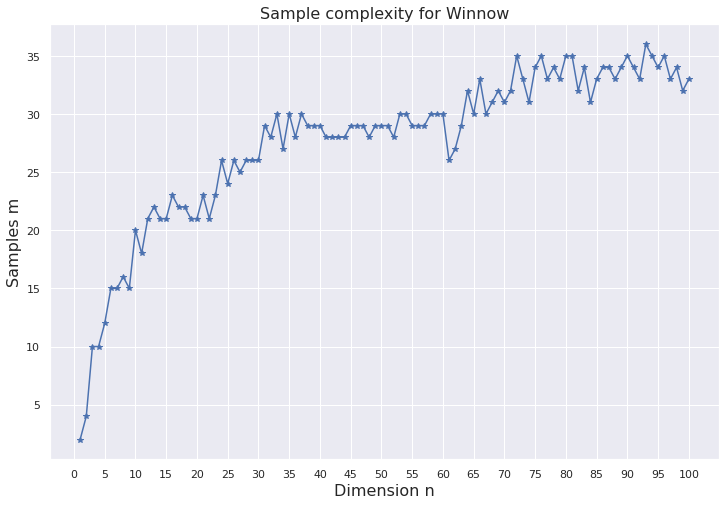

In [ ]:
n , m_winnow = estimate_sample_complexity('Winnow', max_dim=100, test_set_size=300, n_runs=50)
plt.figure(figsize=(12,8))
plt.plot(n, m_winnow, '-*');
plt.title('Sample complexity for Winnow', size=16)
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);
plt.xticks([x for x in range(0,n[-1]+5, 5)]);

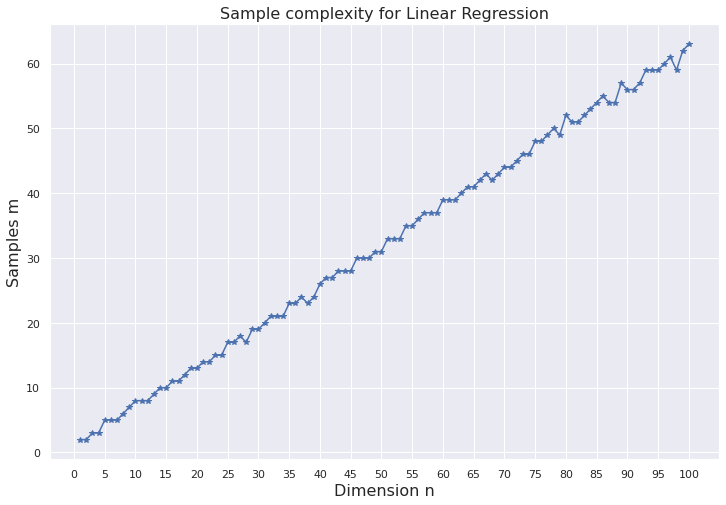

In [ ]:
n , m_regression = estimate_sample_complexity('Linear Regression', max_dim=100, test_set_size=300, n_runs=50)
plt.figure(figsize=(12,8))
plt.plot(n, m_regression, '-*');
plt.title('Sample complexity for Linear Regression', size=16)
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);
plt.xticks([x for x in range(0,n[-1]+5, 5)]);

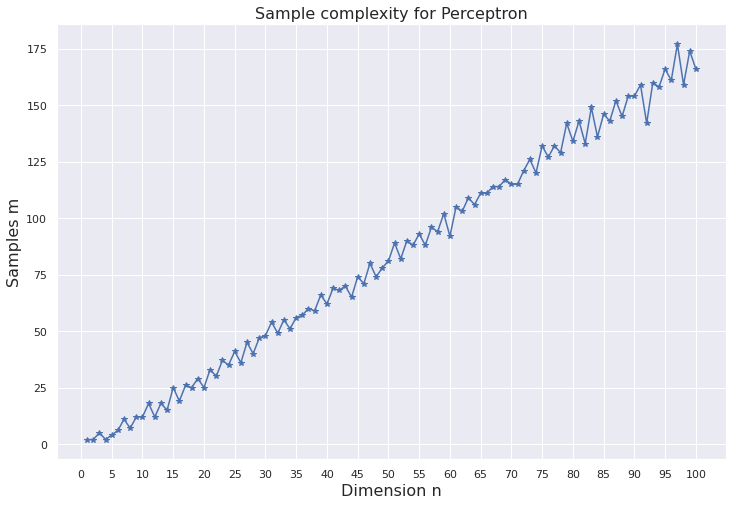

In [ ]:
n , m_perceptron = estimate_sample_complexity('Perceptron', max_dim=100, test_set_size=300, n_runs=50)
plt.figure(figsize=(12,8))
plt.plot(n, m_perceptron, '-*');
plt.title('Sample complexity for Perceptron', size=16)
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);
plt.xticks([x for x in range(0,n[-1]+5, 5)]);

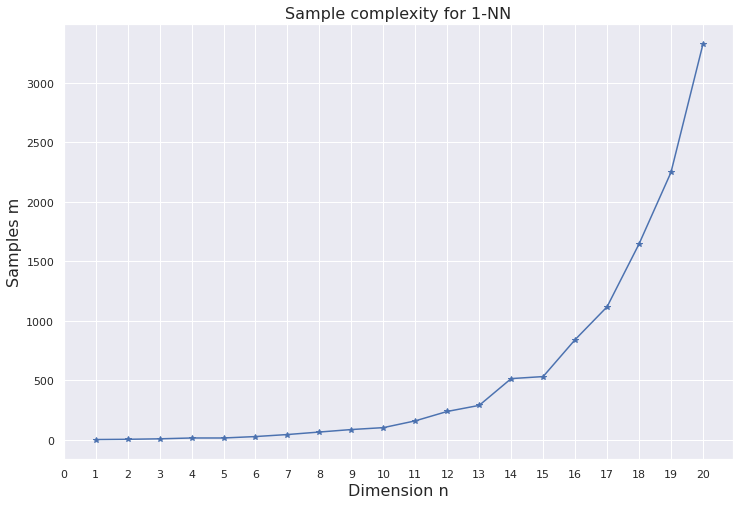

In [ ]:
n , m_knn = estimate_sample_complexity('KNN', max_dim=20, test_set_size=300, n_runs=5)
plt.figure(figsize=(12,8))
plt.plot(n, m_knn, '-*');
plt.title('Sample complexity for 1-NN', size=16)
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);
plt.xticks([x for x in range(0,n[-1]+1)]);

In [ ]:
print(m_knn)

[3, 5, 9, 16, 16, 28, 45, 66, 87, 103, 160, 239, 290, 515, 532, 842, 1118, 1646, 2248, 3325]


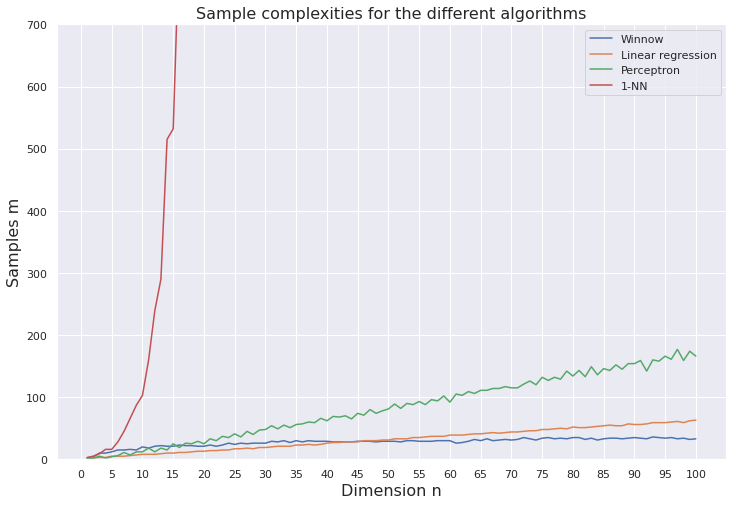

In [ ]:
# Let's plot all four algorithms on the same graph
n = np.arange(1, 101)
plt.figure(figsize=(12,8))
plt.plot(n, m_winnow, label = 'Winnow');
plt.plot(n, m_regression, label = 'Linear regression');
plt.plot(n, m_perceptron, label = 'Perceptron');
plt.plot(n, np.concatenate((m_knn, m_knn[-1] * np.ones(len(m_perceptron) - len(m_knn)))), label = '1-NN');
plt.title('Sample complexities for the different algorithms', size=16)
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);
plt.ylim((0,700));
plt.legend();
plt.xticks([x for x in range(0,n[-1]+5, 5)]);

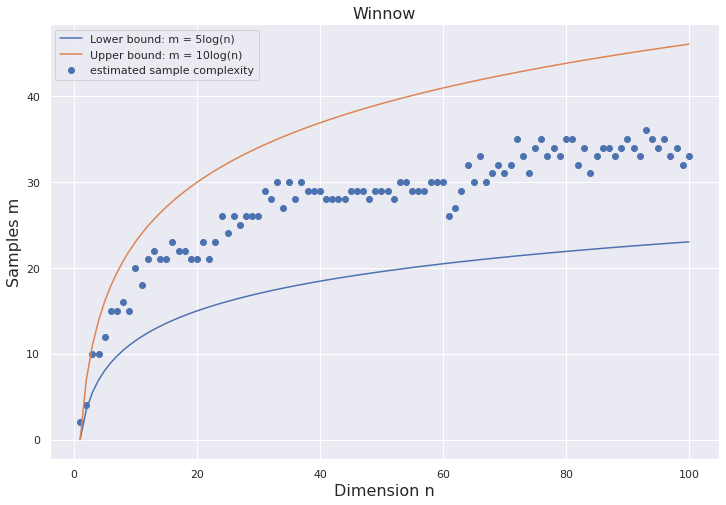

In [ ]:
# Part (c)

# Winnow complexity analysis

n = np.arange(1,101)
plt.figure(figsize=(12,8))
plt.scatter(n, m_winnow, label='estimated sample complexity');
plt.plot(n, 5 * np.log(n), label = 'Lower bound: m = 5log(n)')
plt.plot(n, 10 * np.log(n), label = 'Upper bound: m = 10log(n)')
plt.title('Winnow', size=16)
plt.legend();
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);

In [ ]:
# Winnow - Regress sample complexity on log(dimensionality)
n = np.arange(1,101)
mod = sm.OLS(m_winnow, np.log(n)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          3.436e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):                   1.23e-127
Time:                        13:59:05   Log-Likelihood:                         -183.82
No. Observations:                 100   AIC:                                      369.6
Df Residuals:                      99   BIC:                                      372.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.5498      0.041    185.366      0.000       7.469       7.631
==============================================================================
Omnibus:                        3.433   Durbin-Watson:                   1.290
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.968
Skew:                          -0.257   Prob(JB):                        0.227
Kurtosis:                       3.669   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

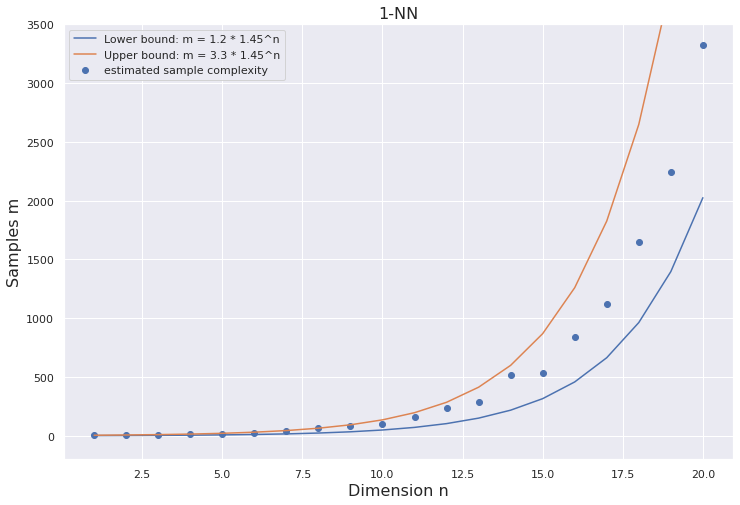

In [ ]:
# 1-NN complexity analysis

n = np.arange(1,21)
plt.figure(figsize=(12,8))
plt.scatter(n, m_knn, label='estimated sample complexity');
plt.plot(n, 1.2 * 1.45**n, label = 'Lower bound: m = 1.2 * 1.45^n')
plt.plot(n, 3.3 * 1.45**n, label = 'Upper bound: m = 3.3 * 1.45^n')
plt.ylim((-200, 3500))
plt.title('1-NN', size=16)
plt.legend();
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);

In [ ]:
# 1-NN - Regress sample complexity on 1.45^(dimensionality)
mod = sm.OLS(m_knn, 1.45**n).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              8269.
Date:                Sun, 12 Dec 2021   Prob (F-statistic):                    1.51e-26
Time:                        10:45:19   Log-Likelihood:                         -106.48
No. Observations:                  20   AIC:                                      215.0
Df Residuals:                      19   BIC:                                      216.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9878      0.022     90.936      0.000       1.942       2.034
==============================================================================
Omnibus:                        9.346   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                7.555
Skew:                           0.940   Prob(JB):                       0.0229
Kurtosis:                       5.352   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

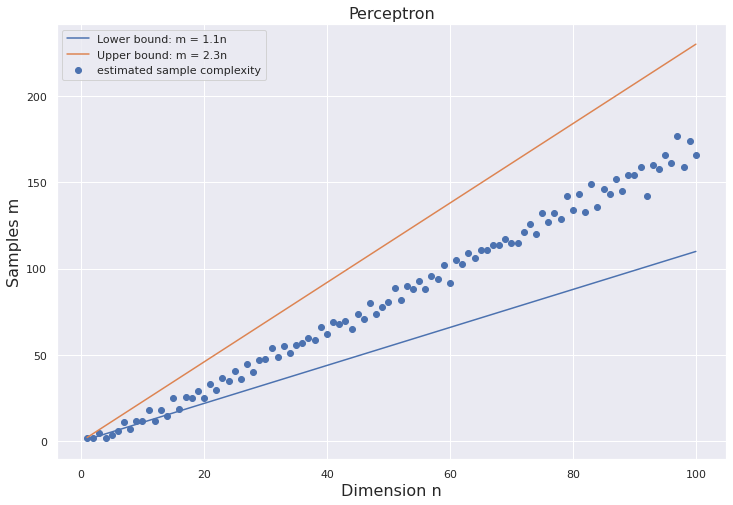

In [ ]:
# Perceptron complexity analysis

n = np.arange(1,101)
plt.figure(figsize=(12,8))
plt.scatter(n, m_perceptron, label='estimated sample complexity');
plt.plot(n, 1.1 * n, label = 'Lower bound: m = 1.1n')
plt.plot(n, 2.3 * n, label = 'Upper bound: m = 2.3n')
plt.title('Perceptron', size=16)
plt.legend();
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);

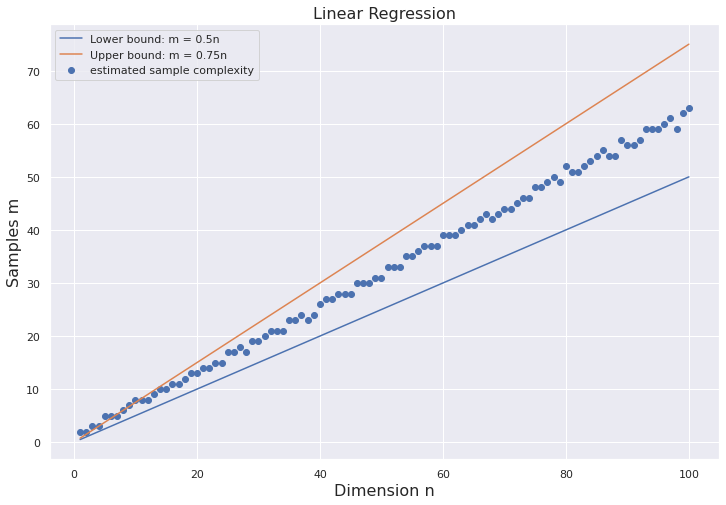

In [ ]:
# Linear regression complexity analysis

n = np.arange(1,101)
plt.figure(figsize=(12,8))
plt.scatter(n, m_regression, label='estimated sample complexity');
plt.plot(n, 0.5 * n, label = 'Lower bound: m = 0.5n')
plt.plot(n, 0.75 * n, label = 'Upper bound: m = 0.75n')
plt.title('Linear Regression', size=16)
plt.legend();
plt.xlabel('Dimension n', size = 16)
plt.ylabel('Samples m', size = 16);